In [9]:
# specifying the zip file name
file_name = "./hand_palm_dorsal_training/split_dataset.zip"
destination = "./hand_palm_dorsal_training"


import zipfile
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    print('Extracting all the files now...')
    zip_ref.extractall(destination)
    print('Done!')

Extracting all the files now...
Done!


In [ ]:
# Libraries Importation

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import os
from livelossplot.inputs.keras import PlotLossesCallback

In [12]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [17]:
train_data_dir =  "./hand_palm_dorsal_training/split_dataset/train"
test_data_dir = "./hand_palm_dorsal_training/split_dataset/test"

class_subset = sorted(os.listdir("./hand_palm_dorsal_training/split_dataset/train"))

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 7532 images belonging to 2 classes.
Found 1328 images belonging to 2 classes.
Found 2216 images belonging to 2 classes.


In [19]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [20]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=len(class_subset)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 20

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58900480/58889256 [==============================] - 1s 0us/step


In [21]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

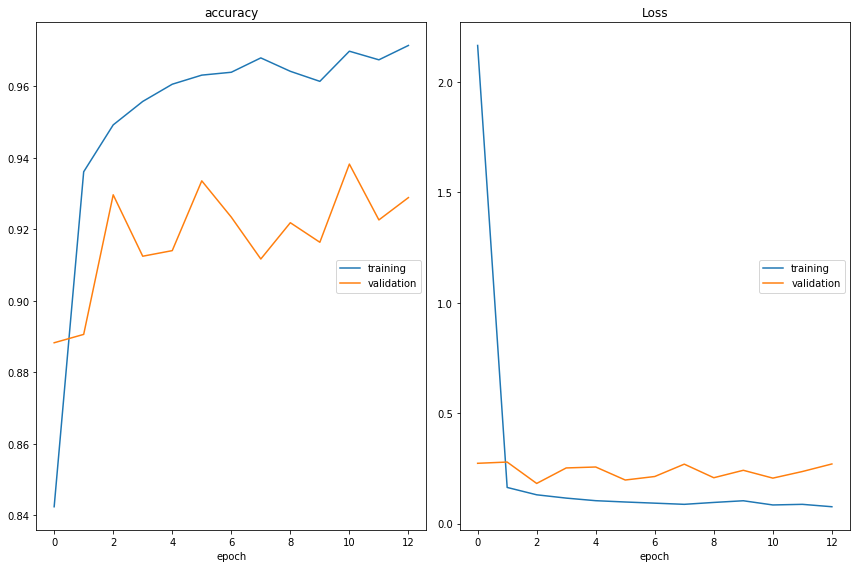

accuracy
	training         	 (min:    0.842, max:    0.971, cur:    0.971)
	validation       	 (min:    0.888, max:    0.938, cur:    0.929)
Loss
	training         	 (min:    0.077, max:    2.165, cur:    0.077)
	validation       	 (min:    0.182, max:    0.279, cur:    0.270)
CPU times: user 2d 5h 11min 54s, sys: 3h 54min 13s, total: 2d 9h 6min 7s
Wall time: 2h 8min 58s


In [22]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [23]:
# Generate predictions
vgg_model.load_weights('./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [24]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 99.05%


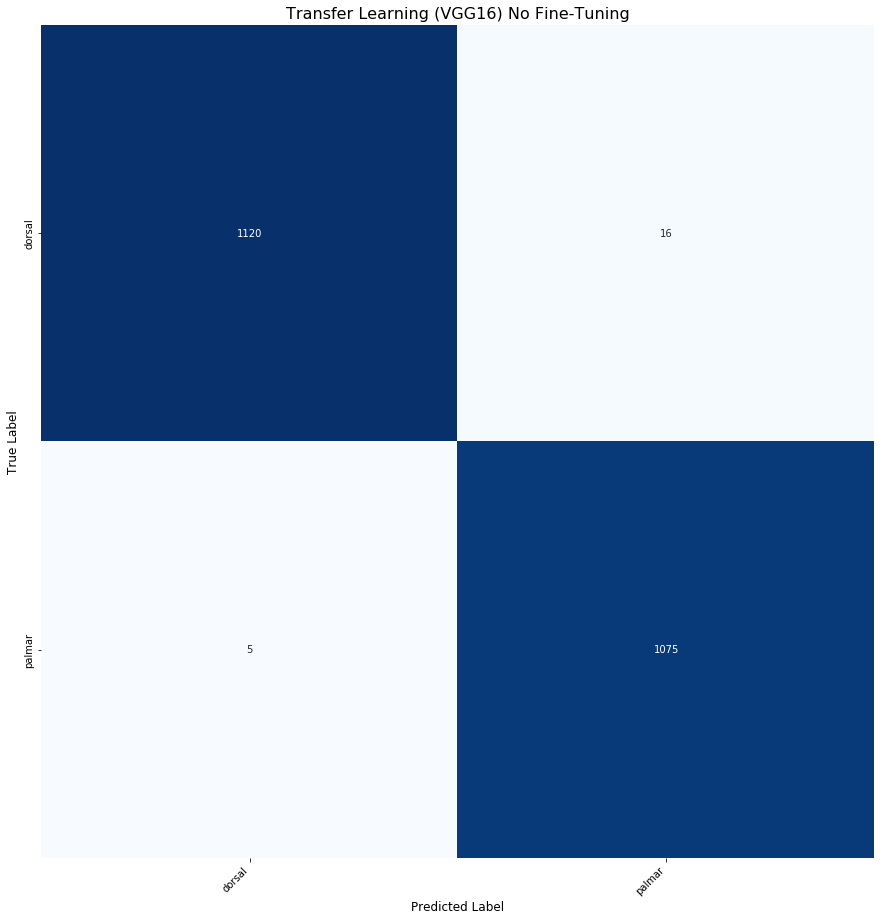

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) No Fine-Tuning")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# Inference

In [53]:
import cv2
from tensorflow.keras.models import load_model
import tensorflow as tf
tf.get_logger().setLevel('INFO')

def inference_func(image_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = tf.reshape(image, [-1, 224, 224, 3])


    inference_model = load_model('./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5') # initialize the best trained weights
    prediction = inference_model.predict(image)[0]
    if max(prediction) == prediction[0]:
        print("Dorsal")
    else:
        print("Palmar")

In [54]:
inference_func("./hand_palm_dorsal_training/split_dataset/test/palmar/Hand_0000056.jpg")

Palmar


In [60]:
inference_func("./hand_palm_dorsal_training/split_dataset/test/dorsal/Hand_0010706.jpg")

Dorsal


## Convert Model to tflite

In [65]:
#Code to convert h5 to tflite
import tensorflow as tf

model =tf.keras.models.load_model('./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5')

#Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Implement optimization strategy for smaller model sizes
tflite_model = converter.convert()
open("./hand_palm_dorsal_training/trained_models/hand_detection_tflite_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppoqoe2ci/assets


487502832

In [100]:
# Get models size

def get_size(file_path, unit='bytes'):
    file_size = os.path.getsize(file_path)
    exponents_map = {'bytes': 0, 'kb': 1, 'mb': 2, 'gb': 3}
    if unit not in exponents_map:
        raise ValueError("Must select from \
        ['bytes', 'kb', 'mb', 'gb']")
    else:
        size = file_size / 1024 ** exponents_map[unit]
        return round(size, 3)

file_path = "./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5"
print(get_size(file_path, 'mb'),"mb")

1282.559 mb


In [68]:
file_path = "./hand_palm_dorsal_training/trained_models/hand_detection_tflite_model.tflite"
print(get_size(file_path, 'mb'),"mb")

464.919 mb


In [82]:
output_details

[{'name': 'Identity',
  'index': 56,
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [71]:
input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [97]:


import numpy as np
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array
from time import time
from matplotlib import pyplot as plt
import os

image_path = "./hand_palm_dorsal_training/split_dataset/test/palmar/Hand_0000056.jpg"

image = load_img(image_path, target_size=(224,224))

image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#print(image.shape)


###############################################
###PREDICT USING REGULAR KERAS TRAINED MODEL FILE (h5). 
##########################################################

keras_model_size = os.path.getsize("./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5")/1048576  #Convert to MB
print("Keras Model size is: ", keras_model_size, "MB")
#Using regular keral model
model = tf.keras.models.load_model("./hand_palm_dorsal_training/trained_models/tl_model_v1.weights.best.hdf5")

time_before=time()
keras_prediction = model.predict(image)
time_after=time()
total_keras_time = time_after - time_before
print("Total prediction time for keras model is: ", total_keras_time)

if max(keras_prediction[0]) == prediction[0]:
    print("Dorsal")
else:
    print("Palmar")

Keras Model size is:  1282.5585174560547 MB
Total prediction time for keras model is:  0.3218190670013428
Palmar


In [106]:
##################################################################################
#### PREDICT USING tflite ###
############################################################################

tflite_size = os.path.getsize("./hand_palm_dorsal_training/trained_models/hand_detection_tflite_model.tflite")/1048576  #Convert to MB
print("tflite Model without opt. size is: ", tflite_size, "MB")
#
tflite_model_path = "./hand_palm_dorsal_training/trained_models/hand_detection_tflite_model.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']

# Load image
input_data = image

interpreter.set_tensor(input_details[0]['index'], input_data)

time_before=time()
interpreter.invoke()
time_after=time()
total_tflite_time = time_after - time_before
print("Total prediction time for tflite without opt model is: ", total_tflite_time)

output_data_tflite = interpreter.get_tensor(output_details[0]['index'])
if max(output_data_tflite[0]) == output_data_tflite[0][0]:
    print("Dorsal")
else:
    print("Palmar")

tflite Model without opt. size is:  464.91893005371094 MB
Total prediction time for tflite without opt model is:  0.5541529655456543
Palmar
